# TauDEM Raster Processing Notebook

This notebook demonstrates basic GIS raster processing on HydroShare Resources.

In [16]:
# import some libaries
%matplotlib inline
import os
import hs_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from osgeo import osr, gdal
import subprocess

# get the data directory (this is an environment variable that is provided to you)
data_directory = os.environ['DATA']

### Define some functions that we will use later

1. **Plot_tiff** will provide some simple plotting so that we can see the results of our TauDEM operations
2. **run** provides us an easy way to execute TauDEM tools via the terminal and prints the console output in realtime

In [17]:
def plot_tiff(tiff, size=(5,5), aspect=1):
    # change the aspect ration to stretch or compress the image
    
    # read the tiff using the gdal library  
    ds = gdal.Open(tiff)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()

    # set all negative values (i.e. nodata) to zero so that the map is displayed properly
    data[data<0] = 0

    # create figure to hold plot (figsize=(width, height))
    plt.figure(figsize=size)

    # plot the DEM and display the results
    plt.imshow(data, cmap='gist_earth', aspect=aspect)
    plt.show()

In [18]:
def run(cmd):
    
    # execute the process
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    
    # Grab stdout line by line as it becomes available.  This will loop until p terminates.
    while p.poll() is None:
        l = p.stdout.readline() # This blocks until it receives a newline.
        print(l.strip().decode('utf-8'))
        
    # When the subprocess terminates there might be unconsumed output 
    # that still needs to be processed.
    print(p.stdout.read().strip().decode('utf-8'))
    

### Create a connection with HydroShare

This step will be replaced with OAuth soon...

In [19]:
# create a hydroshare intance
h = hs_utils.hydroshare()

In [20]:
# login to user account (will be replaced with OAUTH soon)
h.getSecureConnection(email = 'TonyCastronova')

Enter you HydroShare Password: ········
Successfully established a connection with HydroShare


### Retrieve a raster resource using its ID

The raster resouce id can be found by navigating to a resource in HydroShare and selecting the ID from the URL.

In [21]:
# get some resource content. The resource content is returned as a dictionary
resourceid = 'a094bbf301a84e4d83f9982df9bad038'
content = h.getResourceContent(resourceid)

Download successful.
Content is located at: /home/jovyan/work/notebooks/data/a094bbf301a84e4d83f9982df9bad038/a094bbf301a84e4d83f9982df9bad038

Found the following content files: 

[logan.tif]: /home/jovyan/work/notebooks/data/a094bbf301a84e4d83f9982df9bad038/a094bbf301a84e4d83f9982df9bad038/data/contents/logan.tif

[logan.vrt]: /home/jovyan/work/notebooks/data/a094bbf301a84e4d83f9982df9bad038/a094bbf301a84e4d83f9982df9bad038/data/contents/logan.vrt


### Perform raster processing

The following operations demonstrate how TauDEM can be used to perform basic raster processes.

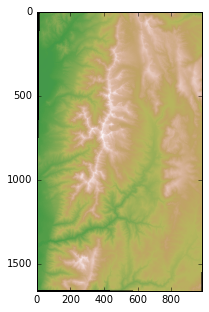

In [22]:
# display the raw dem
raw_dem_path = content['logan.tif']
plot_tiff(raw_dem_path)

In [23]:
# Fill the DEM Pits

# set the output path for the pitremove operation
fill = os.path.join(data_directory, 'fill.tif')
cmd = 'pitremove -z %s -fel %s' % (raw_dem_path, fill)
print(cmd)
run(cmd)

pitremove -z /home/jovyan/work/notebooks/data/a094bbf301a84e4d83f9982df9bad038/a094bbf301a84e4d83f9982df9bad038/data/contents/logan.tif -fel /home/jovyan/work/notebooks/data/fill.tif
PitRemove version 5.3.5
Input file /home/jovyan/work/notebooks/data/a094bbf301a84e4d83f9982df9bad038/a094bbf301a84e4d83f9982df9bad038/data/contents/logan.tif has projected coordinate system.
Processes: 1
Header read time: 0.018312
Data read time: 0.010432
Compute time: 0.845418
Write time: 0.111846
Total time: 0.986008




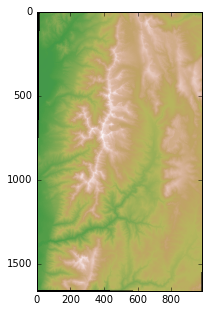

In [24]:
# plot the fill result
plot_tiff(fill)

In [25]:
# Calculate D8 flow direction

# set the output paths for the d8flowdir operation
fdr = os.path.join(data_directory, 'fdr.tif')  # flowdir
sd8 = os.path.join(data_directory, 'sd8.tif')  # slope
cmd = 'd8flowdir -fel %s -sd8 %s -p %s' % (fill, sd8, fdr)
run(cmd)


D8FlowDir version 5.3.5
Input file /home/jovyan/work/notebooks/data/fill.tif has projected coordinate system.
Processors: 1
Header read time: 0.017941
Data read time: 0.141086
Compute Slope time: 0.804080
Write Slope time: 0.125381
Resolve Flat time: 1.248062
Write Flat time: 0.078120
Total time: 2.414670




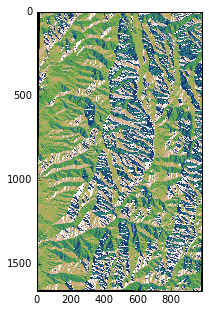

In [26]:
# plot the fdr result
plot_tiff(fdr)

In [27]:
# Calculate D8 contributing area

# set the output paths for the aread8 operation
ad8 = os.path.join(data_directory, 'fdr.tif')  # contributing area
cmd = 'aread8 -p %s -ad8 %s' % (fdr, ad8)
# cmd = 'mpiexec -n 8 aread8 -p %s -ad8 %s' % (fdr, ad8)
run(cmd)

AreaD8 version 5.3.5
Input file /home/jovyan/work/notebooks/data/fdr.tif has projected coordinate system.
Number of Processes: 1
Read time: 0.040635
Compute time: 0.901109
Write time: 0.074897
Total time: 1.016641




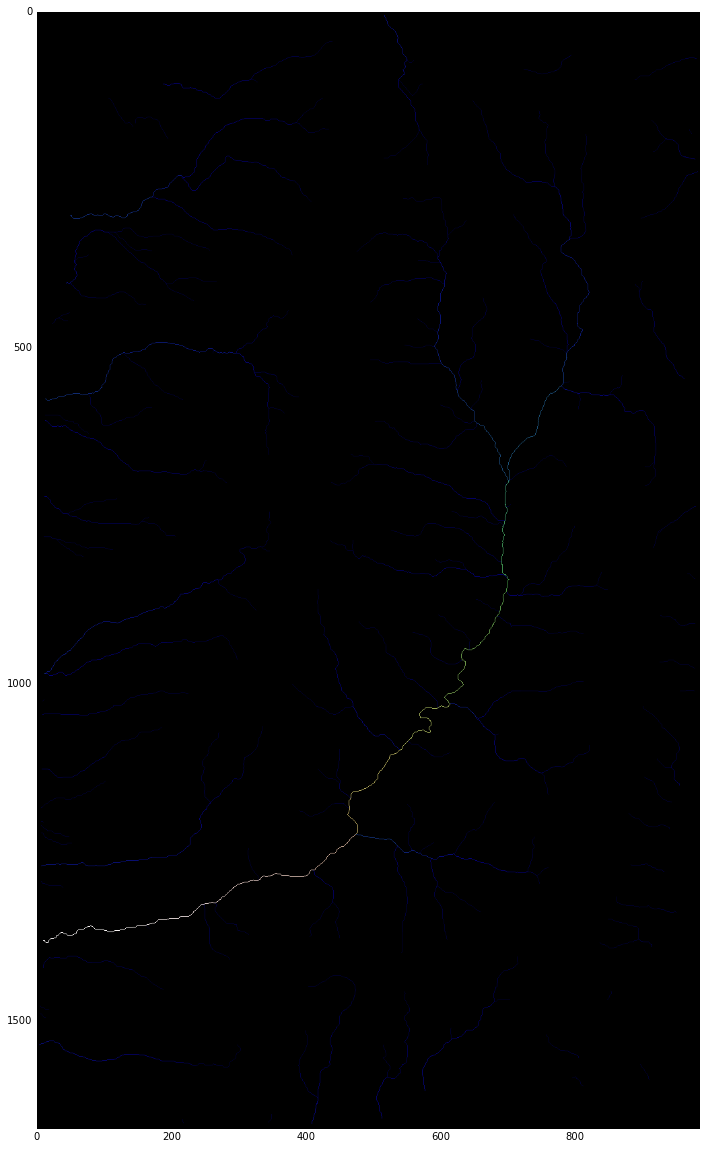

In [28]:
# plot the contributing area result
plot_tiff(ad8, size=(20,20))

### Save the results back into HydroShare

Using the HydroShare rest api, you can create a new resource in HydroShare from a content file.

In [29]:
# save this file as a new resource
abstract = 'This is a D8 contributing area raster that was calculated using TauDEM inside a jupyter notebook'
title = 'Logan Contributing Area'
keywords = ('TauDEM', 'Contributing Area', 'JupyterNotebook')
rtype = 'RasterResource'
fpath = ad8
resource_id = h.hs.createResource(rtype, title, resource_file=fpath, keywords=keywords, abstract=abstract)

# make this resource public too
h.hs.setAccessRules(resource_id, public=True)

u'1488d5d766a94bc6a9367812a0a3b5a1'